In [1]:
# Pull data command:
# python download_data.py --project=discrete-mbrl-minigrid-baseline-best --history_vars n_step random_state_distrib_kl_div random_uniform_distrib_kl_div random_delayed_state_distrib_kl_div goal_state_distrib_kl_div goal_delayed_state_distrib_kl_div goal_uniform_distrib_kl_div explore_right_state_distrib_kl_div explore_right_delayed_state_distrib_kl_div explore_right_uniform_distrib_kl_div --params codebook_size filter_size eval_policy env_name ae_model_type latent_dim final_latent_dim trans_hidden e2e_loss

In [ ]:
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath('../../..'))
from plotting_utils import *

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

%matplotlib inline
set_matplotlib_style()

In [3]:
data_path = 'data/discrete-mbrl-minigrid-baseline-best_data.csv'
df = pd.read_csv(data_path, index_col=0)
df['Model Type'] = df['ae_model_type']

model_type_map = {
  'ae': 'Continuous',
  'vqvae': 'Discrete',
  'fta_ae': 'FTA'
}
df['Model Type'] = df['Model Type'].apply(lambda x: model_type_map[x])
df['Model Type'] = df.apply(
  (lambda x: 'End-to-End' if x['e2e_loss'] == True else x['Model Type']),
  axis=1)

df.head()

,step,n_step,ae_model_type,codebook_size,env_name,filter_size,final_latent_dim,latent_dim,trans_hidden,experiment_key,random_state_distrib_kl_div,random_uniform_distrib_kl_div,goal_state_distrib_kl_div,goal_delayed_state_distrib_kl_div,goal_uniform_distrib_kl_div,explore_right_state_distrib_kl_div,explore_right_delayed_state_distrib_kl_div,explore_right_uniform_distrib_kl_div,e2e_loss,Model Type
0,0,0,ae,None,MiniGrid-Empty-6x6-v0-fullobs,8,64,64,64,46b12c3cc8d54b228a2271cd882d7a92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Continuous
1,1,1,ae,None,MiniGrid-Empty-6x6-v0-fullobs,8,64,64,64,46b12c3cc8d54b228a2271cd882d7a92,0.000406,2.963147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Continuous
2,2,2,ae,None,MiniGrid-Empty-6x6-v0-fullobs,8,64,64,64,46b12c3cc8d54b228a2271cd882d7a92,0.002527,2.401293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Continuous
3,3,3,ae,None,MiniGrid-Empty-6x6-v0-fullobs,8,64,64,64,46b12c3cc8d54b228a2271cd882d7a92,0.004527,2.060746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Continuous
4,4,4,ae,None,MiniGrid-Empty-6x6-v0-fullobs,8,64,64,64,46b12c3cc8d54b228a2271cd882d7a92,0.028107,1.829028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Continuous


In [4]:
kl_div_columns = [col for col in df.columns if 'kl_div' in col]
# Drop the rows where all of the columns are NaN
df = df.dropna(subset=kl_div_columns, how='all')

In [5]:
# Work out the policy types and simplify the KL divergence columns

def infer_policy_type(row):
  for key, val in row.items():
    if 'kl_div' in key and val is not None and not np.isnan(val):
      return key[:key.find('state')-1]
    

df['policy_type'] = df.apply(infer_policy_type, axis=1)
df['state_distrib_kl_div'] = df.apply(
  lambda row: row[row['policy_type'] + '_state_distrib_kl_div'],
  axis=1)
df['uniform_distrib_kl_div'] = df.apply(
  lambda row: row[row['policy_type'] + '_uniform_distrib_kl_div'],
  axis=1)
# df['delayed_state_distrib_kl_div'] = df.apply(
#   lambda row: row[row['policy_type'] + '_delayed_state_distrib_kl_div'] \
#     if row['policy_type'] != 'random' else np.nan,
#   axis=1)

df.drop(columns=kl_div_columns, inplace=True)

Model Type
Continuous    27
Discrete      30
Name: experiment_key, dtype: int64


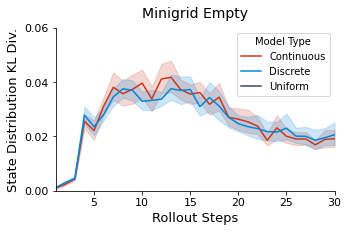

Model Type
Continuous    21
Discrete      21
End-to-End    20
FTA           21
Name: experiment_key, dtype: int64


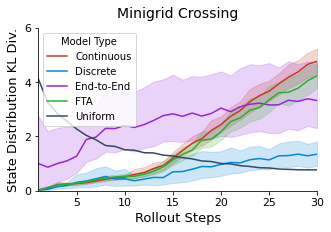

Model Type
Continuous    21
Discrete      21
Name: experiment_key, dtype: int64


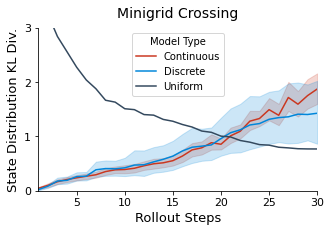

Model Type
Continuous    21
Discrete      21
End-to-End    20
FTA           21
Name: experiment_key, dtype: int64


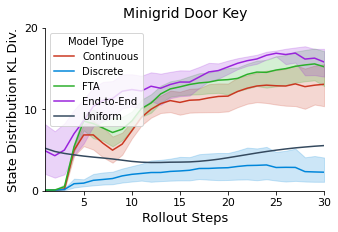

In [6]:
min_runs = 30
for keys, group in df.groupby(['env_name', 'policy_type', 'trans_hidden']):
    n_runs = len(group['experiment_key'].unique())
    min_runs = min(min_runs, n_runs)

for group_keys, group in df.groupby(['env_name', 'policy_type', 'trans_hidden']):
  env_name = group_keys[0]
  max_step = group['step'].max()
  # Print number of unique experiment_key values per Model Type
  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  if 'crossing' in env_name.lower():
    max_step = int(6e5)
  elif 'key' in env_name.lower():
    max_step = int(1e6)

  baseline_row_sets = []
  for baseline_type in ['uniform']:
    with warnings.catch_warnings():
      warnings.simplefilter('ignore')
      if keys[1] == 'random' and baseline_type == 'delayed_state':
        continue
      baseline_rows = group[group['ae_model_type'] == 'ae']
      baseline_rows['state_distrib_kl_div'] = baseline_rows[f'{baseline_type}_distrib_kl_div']
      baseline_title = baseline_type.replace('_', ' ').title()
      baseline_rows['Model Type'] = f'{baseline_title}'
      baseline_rows['experiment_key'] = baseline_rows['experiment_key'] \
        + f'_{baseline_type}_baseline'
      baseline_rows = baseline_rows[
        baseline_rows['experiment_key'] == baseline_rows['experiment_key'].iloc[0]
      ]
      if baseline_type == 'delayed_state':
        # Drop n_step = 1
        baseline_rows = baseline_rows.drop(
          baseline_rows[baseline_rows['n_step'] == 1].index)
      baseline_row_sets.append(baseline_rows)
  group = pd.concat([group, *baseline_row_sets])

  max_base_y = np.percentile(group['state_distrib_kl_div'], 95)
  color_palette = get_color_palette(group['Model Type'].unique())
  
  sns.lineplot(
    data=group, x='n_step', y='state_distrib_kl_div', hue='Model Type',
    palette=color_palette, errorbar='ci', estimator=np.mean)
  
  plt.title(f'{standardize_env_name(group_keys[0])}')
  set_fig_labels('Rollout Steps', 'State Distribution KL Div.')

  plt.xlim(1, 30)
  plt.ylim(0, 1.1 * max_base_y)

  yticks = plt.gca().get_yticks()
  plt.gca().set_yticks(yticks[::2])

  save_fig_versions(f'{standardize_env_name(group_keys[0])}_baseline')
  plt.show()


Plotted runs: 30
57
Model Type
Continuous    27
Discrete      30
Name: experiment_key, dtype: int64
83
Model Type
Continuous    21
Discrete      21
End-to-End    20
FTA           21
Name: experiment_key, dtype: int64
83
Model Type
Continuous    21
Discrete      21
End-to-End    20
FTA           21
Name: experiment_key, dtype: int64


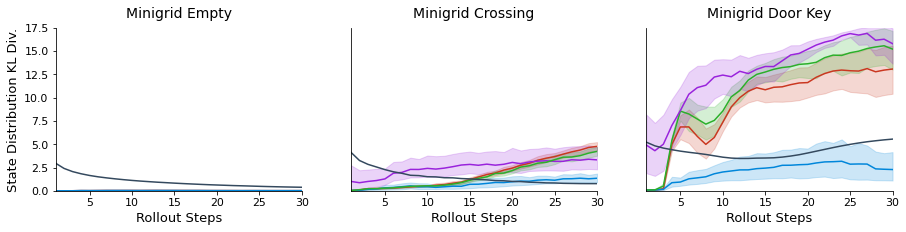

In [7]:
partial_df = df[~(
    (df['env_name'] == 'minigrid-crossing-stochastic') &
    (df['trans_hidden'] == 64) 
)]

# Create subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Create a list of unique Model Types
model_types = partial_df['Model Type'].unique().tolist()
model_types.extend(['Uniform'])
color_palette = get_color_palette(model_types)


min_runs = 30
for fig_idx, (keys, group) in enumerate(partial_df.groupby(['env_name', 'policy_type', 'trans_hidden'])):
    n_runs = len(group['experiment_key'].unique())
    min_runs = min(min_runs, n_runs)
print('Plotted runs:', min_runs)


for fig_idx, (keys, group) in enumerate(partial_df.groupby(['env_name', 'policy_type', 'trans_hidden'])):
    ax = axs[fig_idx]
    print(len(group['experiment_key'].unique()))

    env_name = group_keys[0]
    max_step = group['step'].max()
    # Print number of unique experiment_key values per Model Type
    print(group.groupby(['Model Type'])['experiment_key'].nunique())
    if 'crossing' in env_name.lower():
        max_step = int(6e5)
    elif 'key' in env_name.lower():
        max_step = int(1e6)

    baseline_row_sets = []
    for baseline_type in ['uniform']:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            if keys[1] == 'random' and baseline_type == 'delayed_state':
                continue
            baseline_rows = group[group['ae_model_type'] == 'ae']
            baseline_rows['state_distrib_kl_div'] = baseline_rows[f'{baseline_type}_distrib_kl_div']
            baseline_title = baseline_type.replace('_', ' ').title()
            baseline_rows['Model Type'] = f'{baseline_title}'
            baseline_rows['experiment_key'] = baseline_rows['experiment_key'] \
                + f'_{baseline_type}_baseline'
            baseline_rows = baseline_rows[
                baseline_rows['experiment_key'] == baseline_rows['experiment_key'].iloc[0]
            ]
            if baseline_type == 'delayed_state':
                # Drop n_step = 1
                baseline_rows = baseline_rows.drop(
                baseline_rows[baseline_rows['n_step'] == 1].index)
            baseline_row_sets.append(baseline_rows)
    group = pd.concat([group, *baseline_row_sets])

    max_base_y = group['state_distrib_kl_div'].max()
    color_palette = get_color_palette(group['Model Type'].unique())
    
    sns.lineplot(
        data=group, x='n_step', y='state_distrib_kl_div', hue='Model Type',
        palette=color_palette, ax=ax, errorbar='ci', estimator=np.mean)
    
    plt.title(f'{standardize_env_name(keys[0])}')
    set_fig_labels('Rollout Steps', 'State Distribution KL Div.')

    # yticks = plt.gca().get_yticks()
    # plt.gca().set_yticks(yticks[::2])

    ax.set_title(standardize_env_name(keys[0]))

    if fig_idx == 0:
        # Add a legend manually
        for i, model_type in enumerate(color_palette.keys()):
            ax.plot([], [], color=color_palette[model_type], label=model_type)
        ax.legend(title='Model Type')

    else:
        # Remove label from inner plots
        ax.set_ylabel('')

        # Remove y ticks from inner plots
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax.set_xlabel('Rollout Steps')

# Set X and Y labels for outer plots
axs[0].set_ylabel('State Distribution KL Div.')

# Set X and Y limits for all plots
for ax in axs:
    ax.set_xlim(1, 30)
    ax.set_ylim(0, 17.5)

plt.savefig(f'../figures/svg/all_baseline.svg', bbox_inches='tight')
plt.savefig(f'../figures/png/all_baseline.png', bbox_inches='tight', dpi=400)

# Get rid of legend
for ax in axs:
    ax.legend_.remove()

plt.savefig(f'../figures/svg/all_baseline_nl.svg', bbox_inches='tight')
plt.savefig(f'../figures/png/all_baseline_nl.png', bbox_inches='tight', dpi=400)

plt.show()


ae_model_type
ae       27
vqvae    30
Name: n_step, dtype: int64
ae_model_type
ae        41
fta_ae    21
vqvae     21
Name: n_step, dtype: int64
ae_model_type
ae        41
fta_ae    21
vqvae     21
Name: n_step, dtype: int64


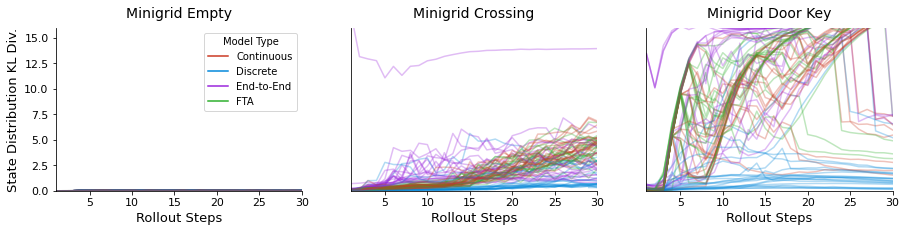

In [8]:
partial_df = df[~(
    (df['env_name'] == 'minigrid-crossing-stochastic') &
    (df['trans_hidden'] == 64) 
)]

# Create subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Create a list of unique Model Types
model_types = partial_df['Model Type'].unique().tolist()
color_palette = get_color_palette(model_types)

min_runs = 30
for fig_idx, (keys, group) in enumerate(partial_df.groupby(['env_name', 'policy_type', 'trans_hidden'])):
    n_runs = len(group['experiment_key'].unique())
    min_runs = min(min_runs, n_runs)

for fig_idx, (keys, group) in enumerate(partial_df.groupby(['env_name', 'policy_type', 'trans_hidden'])):
    ax = axs[fig_idx]
  
    # Count the number of runs (number of times n_step == 30) for each ae_model_type
    max_step = group['n_step'].max()
    print(group[group['n_step'] == max_step].groupby('ae_model_type').count()['n_step'])

    all_runs = {}
    run_type_counter = Counter()

    # Loop through the model types
    for i, model_type in enumerate(model_types):
        # Filter the data for the current model type
        filtered_data = group[group['Model Type'] == model_type]
        # Loop through the individual experiments within the current model type
        for experiment_key, experiment_data in filtered_data.groupby('experiment_key'):
            all_runs[experiment_key] = {
                'data': experiment_data,
                'color': color_palette[model_type]
            }
            run_type_counter[model_type] += 1
            if run_type_counter[model_type] >= min_runs:
                break

    # Loop through the individual experiments in random order
    rand_keys = list(all_runs.keys())
    np.random.shuffle(rand_keys)

    # Move baselines to the end
    for i, key in enumerate(rand_keys):
        if 'baseline' in key:
            rand_keys.append(rand_keys.pop(i))

    for experiment_key in rand_keys:
        # Plot the line with partial transparency
        linestyle = '--' if 'baseline' in experiment_key else '-'
        alpha = 1.0 if 'baseline' in experiment_key else 0.3
        sns.lineplot(
            data=all_runs[experiment_key]['data'],
            x='n_step',
            y='state_distrib_kl_div',
            ax=ax,
            color=all_runs[experiment_key]['color'],
            alpha=alpha,
            legend=False,
        )

    ax.set_title(standardize_env_name(keys[0]))

    if fig_idx == 0:
        # Add a legend manually
        for i, model_type in enumerate(model_types):
            ax.plot([], [], color=color_palette[model_type], label=model_type)
        ax.legend(title='Model Type')

    else:
        # Remove label from inner plots
        ax.set_ylabel('')

        # Remove y ticks from inner plots
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax.set_xlabel('Rollout Steps')

# Set X and Y labels for outer plots
axs[0].set_ylabel('State Distribution KL Div.')

# Set X and Y limits for all plots
for ax in axs:
    ax.set_xlim(1, 30)
    ax.set_ylim(0, 16)

plt.savefig(f'../figures/svg/all_baseline_nb.svg', bbox_inches='tight')
plt.savefig(f'../figures/png/all_baseline_nb.png', bbox_inches='tight', dpi=400)
plt.show()
